<a href="https://drive.google.com/file/d/1-lmvLqHRoVztabnwQ8RbZuDhpsd1kmYY/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIMBRE

**Research project** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Music Instrument Classification***

This project addresses the development of a system for automatic music instrument classification. The dataset
provided is the MedleyDBcollection1, which contains 196 professionally recorded multitrack recordings, including
individual stems corresponding to isolated instruments.
 
Students are tasked with designing a classification pipeline that either recognizes instruments in multitimbral mix
tures or classifies individual stems where typically one instrument is active. The project encourages a flexible
approach, allowing exploration of both isolated and polyphonic scenarios.

Key aspects to investigate include:
- Analyzing the robustness of instrument recognition systems when facing different levels of overlapping in
struments within a mixture.
- Studying the relationship between instrumentation and musical genre, as genre annotations are also available in the dataset.
- Exploring the use of co-occurrence matrices to model and understand typical combinations of instruments within different musical contexts.
The students should experiment with feature extraction techniques sensitive to timbral characteristics, such as
spectral descriptors and MFCCs, and assess the effectiveness of classification

### Team:
* Andrea Crisafulli
* Marco Porcella
* Giacomo De Toni
* Gianluigi Vecchini

## *Import libraries*:

In [1]:
# === Core Python & Scientific Computing ===
import numpy as np                # Numerical computing
import pandas as pd              # Data handling and manipulation
import matplotlib.pyplot as plt  # Plotting
from pathlib import Path         # File path handling
import scipy.signal as signal    # Signal processing tools

# === Audio Processing ===
import librosa                   # Audio analysis
import librosa.display           # Visualization for librosa outputs
import IPython.display as ipd    # For audio playback in notebooks

# === Scikit-learn: ML & Preprocessing ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation
from sklearn.decomposition import PCA         # Dimensionality reduction
from sklearn.preprocessing import scale, StandardScaler, MultiLabelBinarizer  # Data scaling & encoding
from sklearn.model_selection import train_test_split  # Dataset splitting
from sklearn.svm import SVC                    # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # k-NN classifier
from sklearn.cluster import KMeans            # Clustering

# === Deep Learning: TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint  # Training utilities
from keras.optimizers import Adam            # Optimizer for model training
from keras import layers, models

# === Optional: PyTorch (if used) ===
#import torch
#import torch.nn as nn
#import torch.nn.functional as F              # Functional API for building models

# === Others ===
import yaml                                   # Parsing metadata in YAML format
from collections import Counter               # Frequency counting for label analysis
from tqdm import tqdm                         # Progress bar for loops

# === Plotting Style ===
#plt.style.use("seaborn-v0_8")                 # Set default plotting style

2025-06-06 23:44:18.209368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


EXECUTION SETTINGS

In [7]:
# Variables for data extraction
considerMixFiles = True
considerStemFiles = True
considerRawFiles = False

# Variable for OS recognition
OSys = 1                    # 0 = WINDOWS, 1 = MACOS

# Select execution mode for the dataset
executionMode = 1           # 0 = all dataset, 1 = partial dataset

# Select number of classes to extract to form the partial dataset (MAX = 24) (ONLY WORKS IF 1 IS SELECTED FOR executionMode)
n_classes = 10

In [8]:
# Since 83 different labels are present we can group togheter similar labels (24 macrolabels)
labelGroupsDict = {
    'Main System': 'Main System',               # 12

    # Vocals 
    'male singer': 'vocals',                    # 82
    'female singer': 'vocals',                  # 57
    'male rapper': 'vocals',                    # 8
    'male speaker': 'vocals',                   # 2
    'vocalists': 'vocals',                      # 60 

    # Guitar
    'acoustic guitar': 'guitar',                # 50
    'clean electric guitar': 'guitar',          # 94
    'distorted electric guitar': 'guitar',      # 54
    'lap steel guitar': 'guitar',               

    # Small guitars
    'liuqin': 'similar guitars',               
    'banjo': 'similar guitars',
    'mandolin': 'similar guitars',              # 18
    'oud':'similar guitars',
    'zhongruan':'similar guitars',

    # Electric bass and acoustic bass
    'electric bass': 'bass',                    # 126
    'double bass': 'bass',                      # 33

    # Strings
    'violin': 'strings',                        # 41
    'violin section': 'strings',                # 28
    'viola': 'strings',                         # 15
    'viola section': 'strings',                 # 8
    'cello': 'strings',                         # 24
    'cello section': 'strings',
    'string section': 'strings',                # 12
    'erhu': 'strings',

    # Brass
    'trumpet': 'brass',                         # 15
    'trumpet section': 'brass',
    'tuba': 'brass',
    'trombone': 'brass',
    'trombone section': 'brass',
    'french horn': 'brass',
    'french horn section': 'brass',
    'horn section': 'brass',
    'brass section': 'brass',                   # 16

    # Saxophone
    'saxophone': 'saxophone',
    'soprano saxophone': 'saxophone',
    'alto saxophone': 'saxophone',
    'tenor saxophone': 'saxophone',
    'baritone saxophone': 'saxophone',

    # Woodwinds
    'dizi': 'woodwinds',
    'flute': 'woodwinds',                       # 22
    'flute section': 'woodwinds',
    'piccolo': 'woodwinds',
    'clarinet': 'woodwinds',                    # 17
    'clarinet section': 'woodwinds',
    'bass clarinet': 'woodwinds',
    'oboe': 'woodwinds',
    'bassoon': 'woodwinds',                     # 11
    'bamboo flute' : 'woodwinds',

    # Drum set
    'drum set': 'drum set',                     # 131
    'snare drum': 'drum set',
    'kick drum': 'drum set',
    'bass drum': 'drum set',
    'toms': 'percussion',
    'cymbal': 'percussion',                     # 14
    'timpani': 'percussion',                    # 13

    # Percussion
    'doumbek': 'percussion',
    'tabla': 'percussion',                      # 27
    'darbuka': 'percussion',
    'tambourine': 'percussion',
    'shaker': 'percussion',
    'bongo': 'percussion',
    'auxiliary percussion': 'percussion',       # 36
    'claps': 'percussion',
    'gong': 'percussion',
    'gu':'percussion',
    'drum machine': 'percussion',                 # 32
    'scratches': 'percussion',

    # Idiophone
    'chimes': 'idiophone',
    'glockenspiel':'idiophone',
    'vibraphone':'idiophone',                    # 16

    # Harps
    'guzheng':'harps',
    'harp':'harps',
    'yangqin':'harps',                          # 12

    # Piano
    'piano': 'piano',                           # 86

    # Aerophones free reed
    'accordion': 'aerophones',                   # 10
    'harmonica': 'aerophones',                   # 4
    
    # Keyboard and piano
    'electric piano': 'keyboard', 
    'tack piano': 'keyboard',                   # 18
    'melodica': 'keyboard',         
    'sampler': 'keyboard',
    'synthesizer': 'keyboard',                  # 74 

    # fx/processed sound
    'fx/processed sound': 'fx/processed sound',  # 63 
}

### *Import audio data*:

In [9]:
windows = 0
macOS = 1
errorPath = False

if OSys == windows:
    basePath = Path("E:/MedleyDB")                         # For windows
elif OSys == macOS:
    basePath = Path("/Volumes/Extreme SSD/MedleyDB")        # For mac
else:
    errorPath = True

audioPath = basePath / "Audio"
pitch_annotations_dir = basePath / "Annotations" / "Pitch_Annotations"

data = []
startingTimeDict = {}
idx = 0

if (considerMixFiles or considerStemFiles or considerRawFiles and not errorPath):
    # Iterates over directories in the melodyDB/Audio folder
    for songDir in audioPath.iterdir():
        labelArray = []
        
        # Security check to skip not directory items
        if not songDir.is_dir():
            continue
        
        songName = songDir.name
        yamlFilePath = audioPath / songDir / f"{songName}_METADATA.yaml" # Path to YAML metadata file
        
        # Opens YAML metadata file in read mode
        with open(yamlFilePath, "r") as f:
            metadata = yaml.safe_load(f)
        
        # Recovers stems from metadata and stores in dictionary
        stemsData = metadata.get("stems", {})
        
        startingTimes = []
        endingTimes = []

        # Iterates over stems
        for stemId, stem in stemsData.items():
            instrumentData = [] # Empty data for raw paths
            
            rawData = stem.get("raw", {})
            
            # import Raw files (SKIP FOR NOW)
            if considerRawFiles:
                # Iterates over raw items to store the relative paths
                for rawId, raw in rawData.items():
                    rawPath = songDir /  f"{songName}_RAW" / raw.get("filename")
                    
                    # Checks for valid files
                    if(not rawPath.name.startswith(".")):
                        rawData = {
                            "song": songName,
                            "songPath": audioPath / songDir,
                            "label": labelGroupsDict[stem.get("instrument")],
                            "filePath": rawPath
                        }
                        
                        data.append(rawData)
                    idx += 1
                
            # Creates new data
            if considerStemFiles:
                stemData = {
                    "song": songName,
                    "songPath": songDir,
                    "label": labelGroupsDict[stem.get("instrument")],
                    "filePath": songDir / f"{songName}_STEMS" / stem.get("filename")
                }
                
                # Appends to data 
                data.append(stemData)

                # Build expected pitch annotation file name
                stem_num = int(''.join(filter(str.isdigit, stemId)))
                pitch_filename = f"{songName}_STEM_{stem_num:02d}.csv"
                pitch_filepath = pitch_annotations_dir / pitch_filename

                # Extract melodic activity range
                if pitch_filepath.exists():
                    pitch_df = pd.read_csv(
                        pitch_filepath,
                        header=None,
                        names=["time", "frequency"],
                        on_bad_lines="skip"  # or use error_bad_lines=False for older pandas
                    )

                    if not pitch_df.empty:
                        start_time = float(pitch_df["time"].iloc[0])
                        end_time = float(pitch_df["time"].iloc[-1])
                    else:
                        start_time, end_time = None, None
                else:
                    start_time, end_time = None, None
                startingTimes.append(start_time)
                endingTimes.append(end_time)
                
                idx += 1
            
            if considerMixFiles:
                labelArray.append(labelGroupsDict[stem.get("instrument")])
        
        if considerMixFiles:
            # Format
            labelArray = np.unique(labelArray)
            labelFormatted = "|".join(sorted(set(labelArray)))
            
            mixData = {
                "song": songName,
                "songPath": audioPath / songDir,
                "label": labelFormatted,
                "filePath": songDir / f"{songName}_MIX.wav"
            }
            
            data.append(mixData)

            valid_starting_times = list(filter(lambda x: x is not None, startingTimes))
            valid_ending_times = list(filter(lambda x: x is not None, endingTimes))

            if valid_starting_times and valid_ending_times and (len(valid_starting_times) == len(valid_ending_times)):
                avg = []
                for i in range(0, len(valid_starting_times)):
                    avg.append((valid_starting_times[i] + valid_ending_times[i])/2)

                startingTime = np.mean(avg)  
                startingTimeDict[idx] = startingTime
            else:
                startingTime = None
                endingTime = None
                startingTimeDict[idx] = None
            idx += 1

    # Create DataFrame
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} audio files.")

    # String convertion to list
    df["labelList"] = df["label"].str.split("|")

    mlbAllDataset = MultiLabelBinarizer()
    audioLabelsBinary = mlbAllDataset.fit_transform(df["labelList"])
    audioLabelsBinary = np.asarray(audioLabelsBinary)
elif errorPath:
    print("ERROR: defined OS is not supported.")
else:
    print("ERROR: no data to extract with current setup.")

Loaded 978 audio files.


In [10]:
#Head of dataset
df.head()

song  \
0  AClassicEducation_NightOwl   
1  AClassicEducation_NightOwl   
2  AClassicEducation_NightOwl   
3  AClassicEducation_NightOwl   
4  AClassicEducation_NightOwl   

                                            songPath     label  \
0  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...      bass   
1  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...  drum set   
2  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    guitar   
3  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    guitar   
4  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    guitar   

                                            filePath   labelList  
0  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...      [bass]  
1  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...  [drum set]  
2  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    [guitar]  
3  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    [guitar]  
4  /Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...    [guitar]

In [11]:
# Tail of dataset
df.tail()

song                                           songPath  \
973  TheSoSoGlos_Emergency  /Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...   
974  TheSoSoGlos_Emergency  /Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...   
975       Wolf_DieBekherte  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   
976       Wolf_DieBekherte  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   
977       Wolf_DieBekherte  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   

                                                 label  \
973                                          idiophone   
974  bass|drum set|fx/processed sound|guitar|idioph...   
975                                             vocals   
976                                              piano   
977                                       piano|vocals   

                                              filePath  \
973  /Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...   
974  /Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...   
975  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   
976  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   
977  /Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...   

                                             labelList  
973                                        [idiophone]  
974  [bass, drum set, fx/processed sound, guitar, i...  
975                                           [vocals]  
976                                            [piano]  
977                                    [piano, vocals]

In [12]:
# Info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       978 non-null    object
 1   songPath   978 non-null    object
 2   label      978 non-null    object
 3   filePath   978 non-null    object
 4   labelList  978 non-null    object
dtypes: object(5)
memory usage: 38.3+ KB


In [13]:
# Show all labels with their number
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


df_labels = pd.DataFrame(audioLabelsBinary, columns=mlbAllDataset.classes_)
df_labels.sum().sort_values(ascending=False)


guitar                184
vocals                180
bass                  159
drum set              138
percussion            130
strings               121
keyboard               98
piano                  86
woodwinds              71
brass                  64
fx/processed sound     63
similar guitars        35
idiophone              24
harps                  23
aerophones             14
saxophone              12
Main System            12
dtype: int64

In [14]:
# Storing variables
audioFiles = []
audioLabels = []

# Extract paths and labels
for _, row in df.iterrows():
    audioFiles.append(row["filePath"])
    audioLabels.append(row["labelList"])
    

# Security check
if(len(audioFiles) == len(audioLabels)):
    print(f"Extracted files and labels for a total lenght of {len(audioFiles)}")
else:
    print("Error in dataset")

Extracted files and labels for a total lenght of 978


In [15]:
# Flatten all labels and count it's frequencies
all_labels = sum(df["labelList"], [])
label_counts = Counter(all_labels)

if n_classes <= sum(label_counts.values()):
    # Consider the n_classes more present in the dataset
    top_labels = [label for label, _ in label_counts.most_common(n_classes)]
    print("Top labels:", top_labels)

    # Filter the row that have at leat one label that is in top_labels
    df_subset = df[df["labelList"].apply(lambda labels: any(label in top_labels for label in labels))]

    # Extract audio and labels
    audioFilesSubset = df_subset["filePath"].tolist()
    audioLabelsSubset = df_subset["labelList"].tolist()

    # MLB over partial dataset
    mlbPartialDataset = MultiLabelBinarizer(classes=top_labels)
    audioLabelsSubsetBinary = mlbPartialDataset.fit_transform(df_subset["labelList"])
    audioLabelsSubsetBinary = np.asarray(audioLabelsSubsetBinary)

    if len(audioFilesSubset) == len(audioLabelsSubset):
        print(f"Extracted {len(audioFilesSubset)} samples from top {n_classes} labels")
    else:
        print("Mismatch in extracted data")

    print(f"Subset binary label matrix shape: {audioLabelsSubsetBinary.shape}")
else:
    print(f"ERROR: selected n_classes of {n_classes} exceeds the total number of classes in DF ({label_counts})")

Top labels: ['guitar', 'vocals', 'bass', 'drum set', 'percussion', 'strings', 'keyboard', 'piano', 'woodwinds', 'brass']
Extracted 874 samples from top 10 labels
Subset binary label matrix shape: (874, 10)


/opt/miniconda3/envs/enviroment/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Main System', 'aerophones', 'fx/processed sound', 'harps', 'idiophone', 'saxophone', 'similar guitars'] will be ignored
  warnings.warn(


In [16]:
allDataset = 0
partialDataset = 1

# if elif block to choose execution mode between all dataset and partial dataset
if executionMode == allDataset:
    mlb = mlbAllDataset                  # mlb to use
    labelsToLoad = audioLabelsBinary     # audioLabels to use
    audioFilesToExtract = audioFiles     # audio files to load
elif executionMode == partialDataset:
    mlb = mlbPartialDataset
    labelsToLoad = audioLabelsSubsetBinary
    audioFilesToExtract = audioFilesSubset

signals = []
idx = 0

timeExtraction = 10  # in seconds
samplingRate = 22050
num_samples = int(samplingRate * timeExtraction)
minAmplitude = 0.5

# Extraction of files via librosa load (TQDM to show progress)
for x in tqdm(audioFilesToExtract, desc="Loading audio files..."):
    y, _ = librosa.load(x, sr=samplingRate)
    
    # Normalize the signal
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    # Find starting of the interval in which all instruments of the labels are playing
    if startingTimeDict.get(idx) is not None:
        start_index = int(startingTimeDict.get(idx))
    elif np.any(y > minAmplitude):
        start_index = np.argmax(y > minAmplitude)
    else:
        start_index = 0

    # Calculate ending of the interval
    end_index = start_index + num_samples
    
    if end_index <= len(y):
        y = y[start_index:end_index]
    else:
        # try to translate backwards
        if len(y) >= num_samples:
            start_index = len(y) - num_samples
            y = y[start_index:]
        else:
            # Too short: translate foreword
            y = y[start_index:]
            padding_needed = num_samples - len(y)
            y = np.pad(y, (0, padding_needed), 'constant')

    y = y.astype(np.float16)
    signals.append(y)
    idx += 1

Loading audio files...: 100%|██████████| 874/874 [04:26<00:00,  3.28it/s]


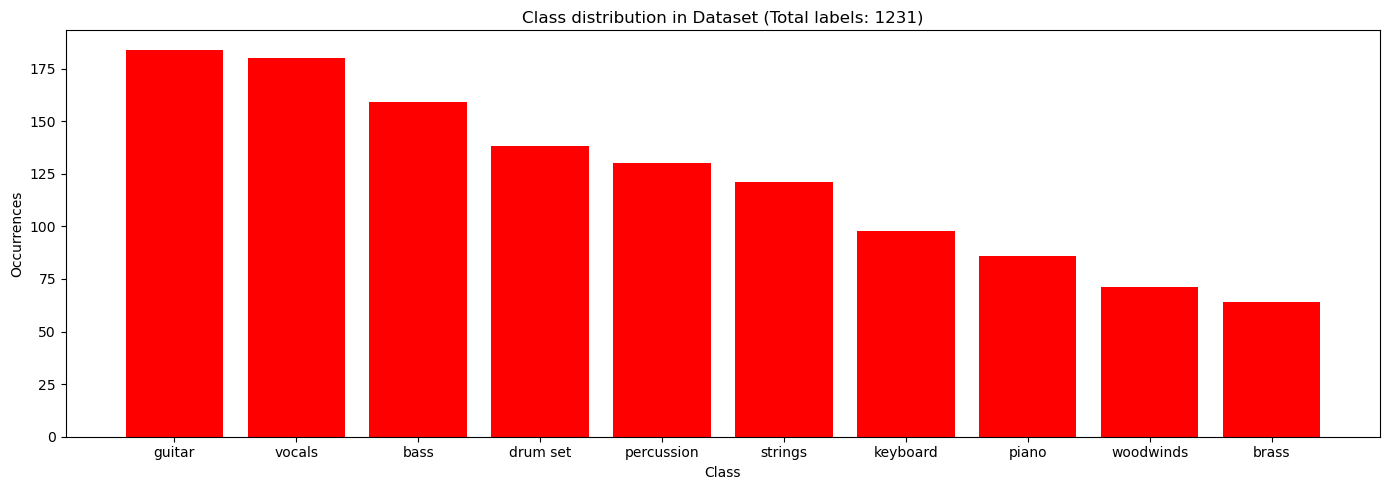

In [19]:
# Count the the number of "1" (active labels) for each class
class_counts = np.sum(labelsToLoad, axis=0)
n_classes = labelsToLoad.shape[1]

# Plot
plt.figure(figsize=(14, 5))
plt.bar(range(n_classes), class_counts, color='red')

# Asse x e titoli
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.xticks(range(n_classes), mlb.classes_)
plt.title(f'Class distribution in Dataset (Total labels: {int(np.sum(labelsToLoad))})')
plt.tight_layout()
plt.show()

In [20]:
melSpegrams = []

# Iterates over signals, normalizes them and computes mel spectrograms via librosa feature
for signal in tqdm(signals, desc="Processing audio signals..."):

    # Creation of mel spectrogram
    S = librosa.feature.melspectrogram(y=signal, sr=22050)
    S_dB = librosa.power_to_db(S, ref=np.max)
    melSpegrams.append(S_dB)

Processing audio signals...: 100%|██████████| 874/874 [00:12<00:00, 69.20it/s]




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('bass',)]


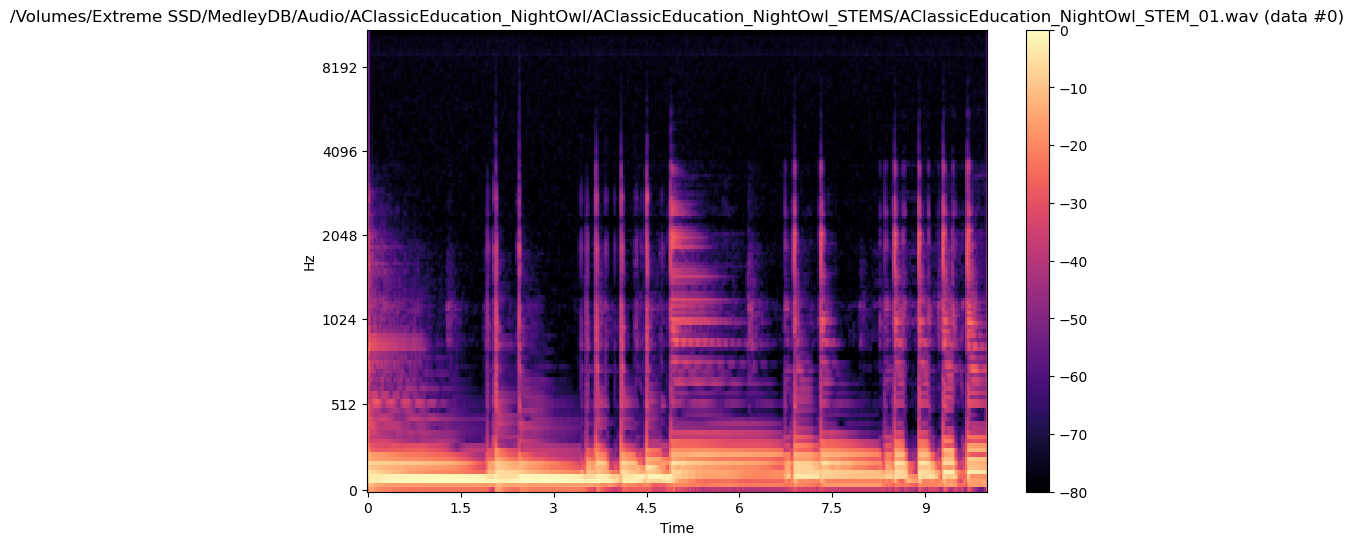



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('drum set',)]


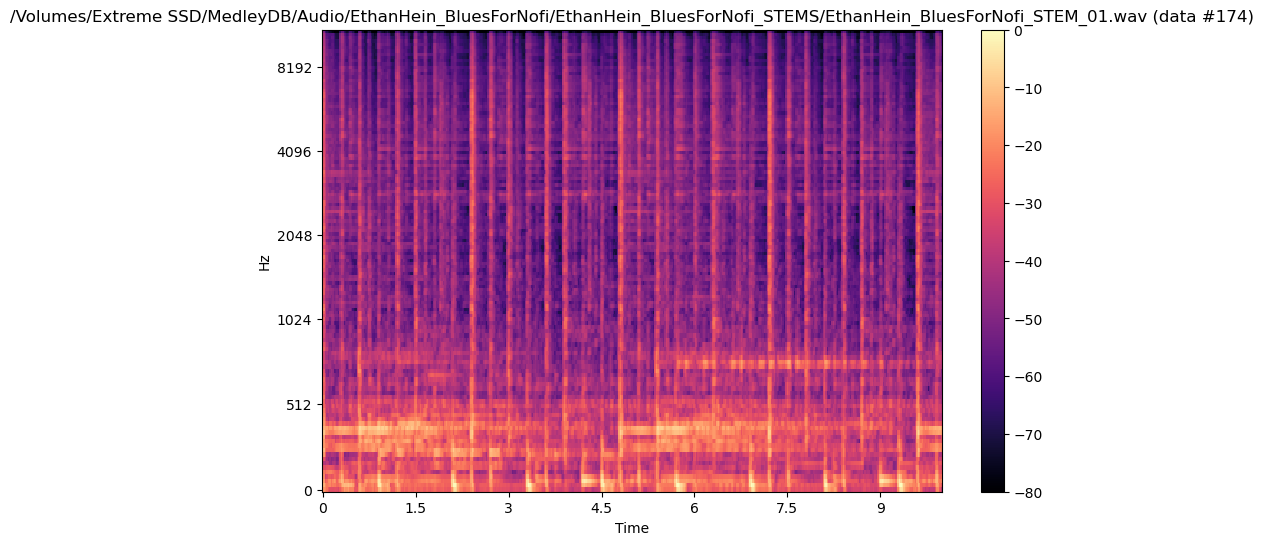



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('percussion',)]


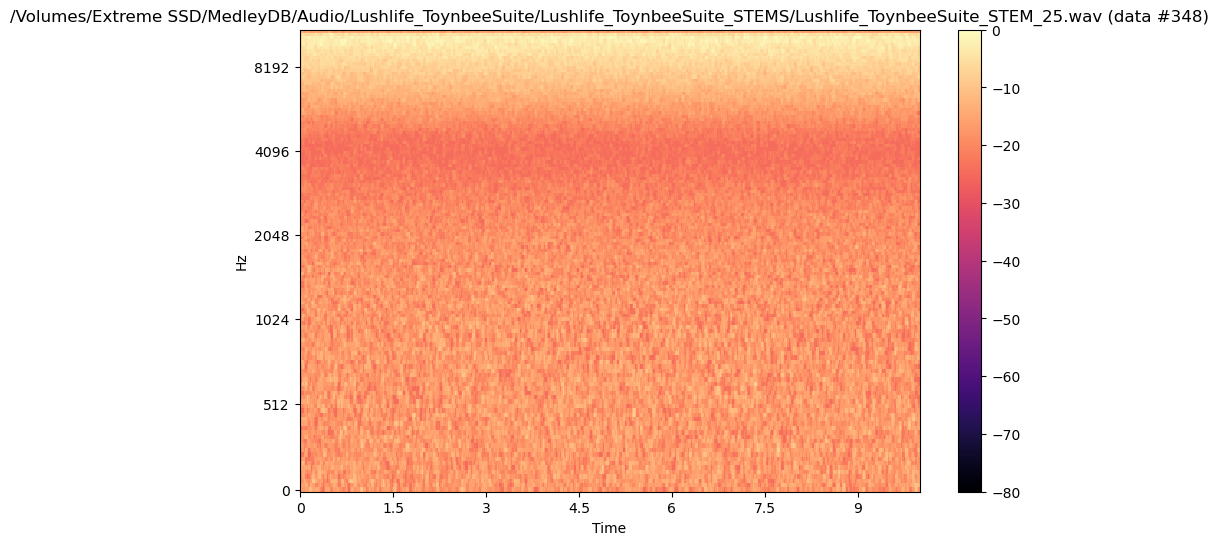



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('percussion', 'strings', 'woodwinds')]


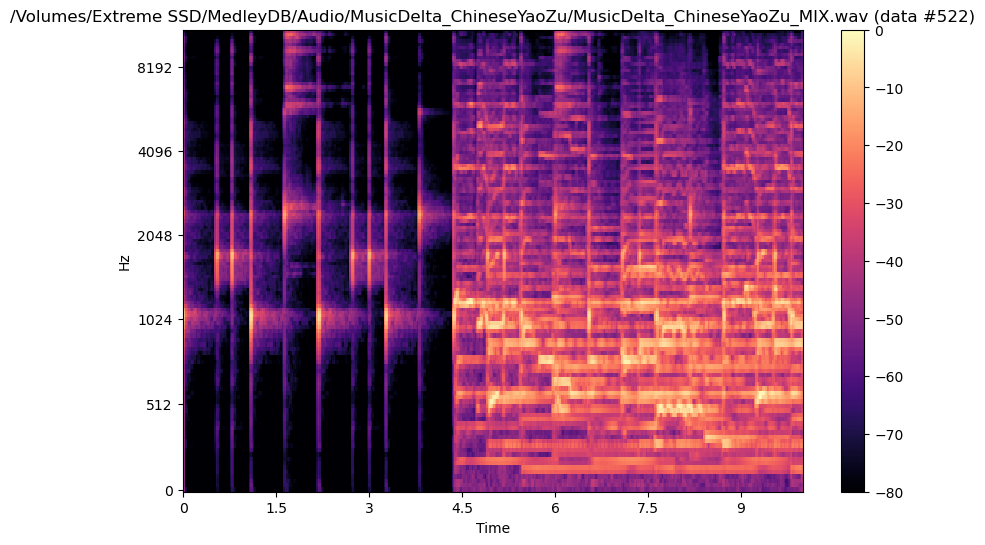



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('guitar',)]


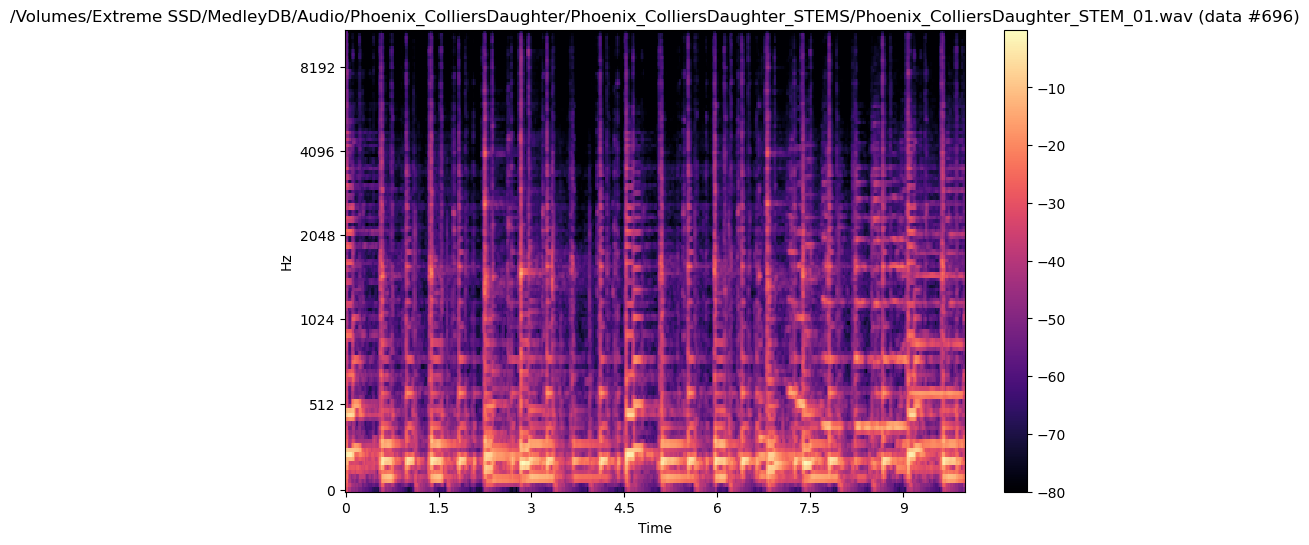



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: [('guitar', 'vocals', 'bass', 'drum set', 'percussion', 'keyboard')]


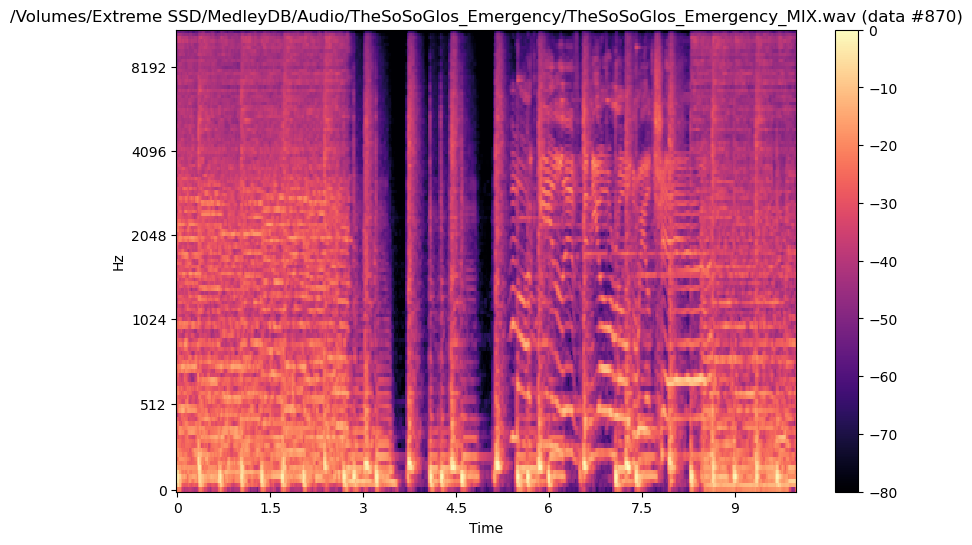

In [21]:
# Plot of spectrograms
import IPython.display

for i in range(0, len(signals), int(len(signals)/5)):
    print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    
    original_labels = mlb.inverse_transform(np.array([labelsToLoad[i]]))
    print("Labels:", original_labels)

    IPython.display.display(IPython.display.Audio(signals[i], rate=22050))

    plt.figure(figsize=(10,6))
    librosa.display.specshow(melSpegrams[i], sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
    plt.clim(-80,None)
    plt.colorbar()

    filename = str(audioFilesToExtract[i]).split("\\")[-1]
    
    plt.title(f'{filename} (data #{i})')
    plt.show()

The user now has to choose which data he wants to load

In [22]:
melSpegrams = np.asarray(melSpegrams)
labelsToLoad = np.asarray(labelsToLoad)

In [23]:
from sklearn.utils import shuffle
#melSpegrams, labelsToLoad = shuffle(melSpegrams, labelsToLoad, random_state=1234)

# Split into Train (70%) and Temp (30%)
# X = mel spectrograms
# y = label
from skmultilearn.model_selection import iterative_train_test_split

# Convert X to numpy array (es. melSpectrograms devono essere np.array)
X = np.array(melSpegrams)
y = np.array(labelsToLoad)

# Split: Train (70%), Temp (30%)
X_train, y_train, X_temp, y_temp = iterative_train_test_split(X, y, test_size=0.30)

# Split: Validation (15%), Test (15%)
X_val, y_val, X_test, y_test = iterative_train_test_split(X_temp, y_temp, test_size=0.5)
# Summary
print(f"Train samples:      {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")
print(f"Test lables:       {len(y_train)}")
print(f"Validation lables: {len(y_val)}")
print(f"Test lables:       {len(y_test)}")


print("Train:", np.sum(y_train, axis=0))
print("Val:  ", np.sum(y_val, axis=0))
print("Test: ", np.sum(y_test, axis=0))

Train samples:      616
Validation samples: 128
Test samples:       130
Test lables:       616
Validation lables: 128
Test lables:       130
Train: [129 126 111  97  91  85  69  60  50  45]
Val:   [28 27 24 20 19 18 15 13 11 10]
Test:  [27 27 24 21 20 18 14 13 10  9]


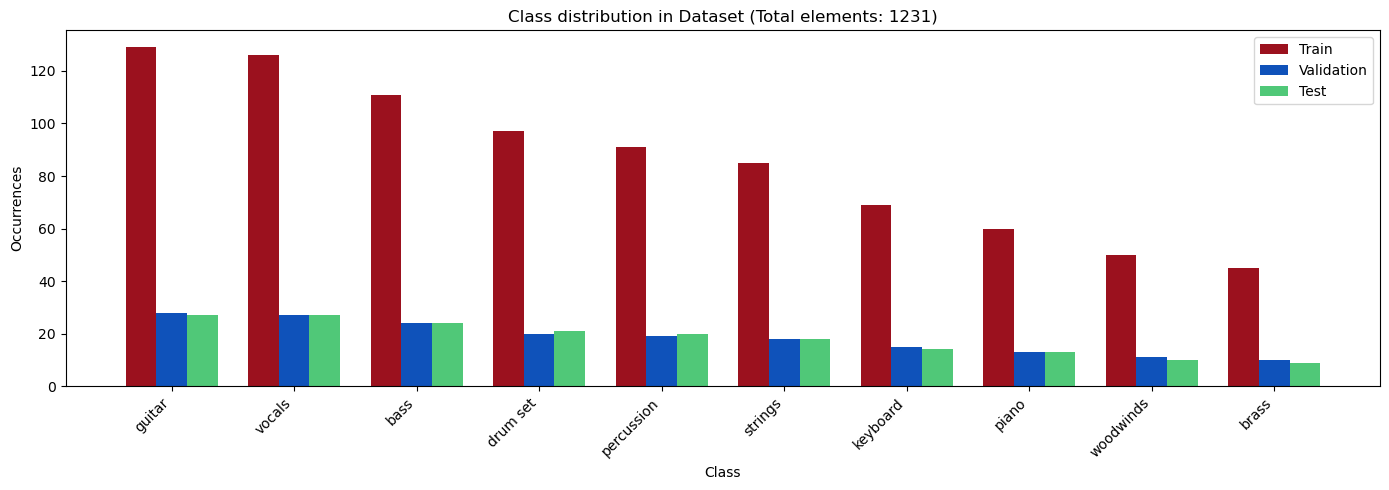

In [24]:
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_val, axis=0)
test_counts = np.sum(y_test, axis=0)

ruby = '#9B111E'
sapphire = '#0F52BA'
emerald = '#50C878'

labelsChart = mlb.classes_
x = np.arange(len(labelsChart))  # posizione per ogni classe
width = 0.25  # larghezza delle barre

plt.figure(figsize=(14, 5))

# Barre
plt.bar(x - width, train_counts, width, label='Train', color=ruby)
plt.bar(x, val_counts, width, label='Validation', color=sapphire)
plt.bar(x + width, test_counts, width, label='Test', color=emerald)

# Asse x e titoli
plt.xticks(x, labelsChart, rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.title(f'Class distribution in Dataset (Total elements: {np.sum(labelsToLoad)})')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import random
import scipy.ndimage

def padding(newSpec, originalShape):
    newShape = newSpec.shape
    # Tile enough to cover the desired shape
    repeat_y = int(np.ceil(originalShape[0] / newShape[0]))
    repeat_x = int(np.ceil(originalShape[1] / newShape[1]))
    # Repeat the content
    tiled = np.tile(newSpec, (repeat_y, repeat_x))
    # Crop to the target shape
    return tiled[:originalShape[0], :originalShape[1]]

def augmenter(spegram):
    originalShape = spegram.shape
    modifications = []

    # Time stretch
    if random.random() < 0.75:
        rate = random.uniform(0.5, 1.5)
        stretched = scipy.ndimage.zoom(spegram, (1, rate), order=1)
        spegram = padding(stretched, originalShape)
        modifications.append(f"time_stretch({rate:.2f})")

    # Pitch shift
    if random.random() < 0.75:
        semitones = random.uniform(-12, 12)
        freqFactor = 2 ** (semitones / 12)
        shifted = scipy.ndimage.zoom(spegram, (freqFactor, 1), order=1)
        spegram = padding(shifted, originalShape)
        modifications.append(f"pitch_shift({semitones:.2f})")

    if not modifications:
        modifications.append("none")

    return spegram, modifications

In [29]:
# Get max class count
max_count = np.max(train_counts)

# Initialize new lists with existing training data
X_train_balanced = list(X_train)
y_train_balanced = list(y_train)

print("Augmenting underrepresented classes...\n")

# For each class add the needed samples augmentation
for class_idx in range(n_classes):
    current_count = train_counts[class_idx]
    needed = int(max_count - current_count)

    if needed <= 0:
        continue

    # Find indices where this class is present in y_train
    candidate_indices = [i for i, label in enumerate(y_train) if label[class_idx] == 1]

    print(f"Class {mlb.classes_[class_idx]}: augmenting {needed} samples")

    # Randomly sample with replacement from those indices
    for _ in tqdm(range(needed)):
        idx_to_copy = random.choice(candidate_indices)

        # Augment the corresponding spectrogram
        augmented_spec, _ = augmenter(X_train[idx_to_copy])

        # Append to the balanced list
        X_train_balanced.append(augmented_spec)
        y_train_balanced.append(y_train[idx_to_copy])

# Convert back to numpy arrays
X_train_balanced = np.array(X_train_balanced)
y_train_balanced = np.array(y_train_balanced)

print(f"\nFinal balanced training set size: {len(X_train_balanced)}")


Augmenting underrepresented classes...

129
126
Class vocals: augmenting 3 samples


100%|██████████| 3/3 [00:00<00:00, 399.57it/s]


111
Class bass: augmenting 18 samples


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 151.03it/s]


97
Class drum set: augmenting 32 samples


100%|██████████| 32/32 [00:00<00:00, 172.20it/s]


91
Class percussion: augmenting 38 samples


100%|██████████| 38/38 [00:00<00:00, 164.15it/s]


85
Class strings: augmenting 44 samples


100%|██████████| 44/44 [00:00<00:00, 242.04it/s]


69
Class keyboard: augmenting 60 samples


100%|██████████| 60/60 [00:00<00:00, 241.85it/s]


60
Class piano: augmenting 69 samples


100%|██████████| 69/69 [00:00<00:00, 299.70it/s]


50
Class woodwinds: augmenting 79 samples


100%|██████████| 79/79 [00:00<00:00, 345.30it/s]


45
Class brass: augmenting 84 samples


100%|██████████| 84/84 [00:00<00:00, 357.42it/s]



Final balanced training set size: 1043


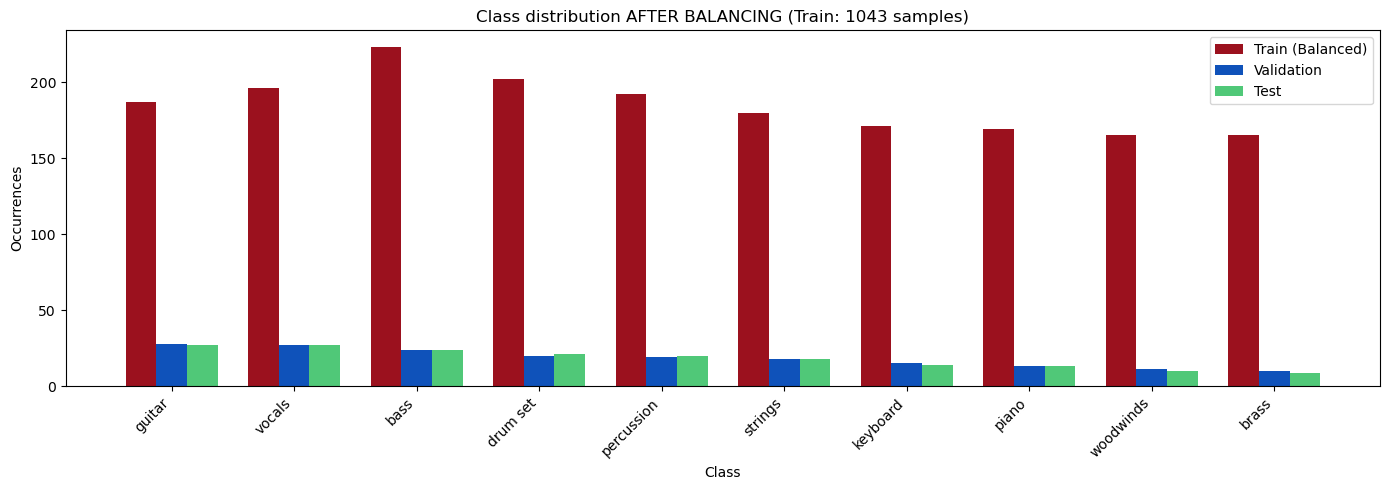

In [27]:
# Recompute class counts for the balanced training set
new_train_counts = np.sum(y_train_balanced, axis=0)
val_counts = np.sum(y_val, axis=0)
test_counts = np.sum(y_test, axis=0)

# Colors (same as before)
ruby = '#9B111E'
sapphire = '#0F52BA'
emerald = '#50C878'

labelsChart = mlb.classes_
x = np.arange(len(labelsChart))  # Class index positions
width = 0.25  # Bar width

# Plot
plt.figure(figsize=(14, 5))
plt.bar(x - width, new_train_counts, width, label='Train (Balanced)', color=ruby)
plt.bar(x, val_counts, width, label='Validation', color=sapphire)
plt.bar(x + width, test_counts, width, label='Test', color=emerald)

plt.xticks(x, labelsChart, rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Occurrences')
plt.title(f'Class distribution AFTER BALANCING (Train: {len(y_train_balanced)} samples)')
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
# === Define input shape and number of output classes ===
inputShape = (128, melSpegrams[0].shape[1], 1)  # (n_mels, time_frames, channels)
numClasses = labelsToLoad.shape[1]              # number of multilabel classes

# === Build CNN model ===
modelCNN = models.Sequential([

    # Input
    layers.Input(shape=inputShape),

    # === Block 1 ===
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 2 ===
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 3 ===
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),

    # === Block 4 ===
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.25),

    # === Fully Connected ===
    # layers.GlobalMaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),

    # === Output Layer (sigmoid for multilabel) ===
    layers.Dense(numClasses, activation='sigmoid')
])

# === Compile the model ===
from keras.metrics import BinaryAccuracy, AUC
modelCNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(multi_label=True, name='auc')]
)

# === Summary ===
modelCNN.summary()

# Optional: show classes
print(f"Number of classes: {numClasses}")
print(f"Class names: {mlb.classes_}")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 128, 431, 32)      320       
                                                                 
 conv2d_57 (Conv2D)          (None, 128, 431, 32)      9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 144, 32)      0         
 g2D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 43, 144, 32)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 43, 144, 64)       18496     
                                                                 
 conv2d_59 (Conv2D)          (None, 43, 144, 64)       36928     
                                                      

In [66]:
# Path to save logs and models
csvLogPath = 'training_log.csv'
checkpointPath = 'best_model.h5'

# CSVLogger: logs every epoch to CSV
csvLogger = CSVLogger(csvLogPath, append=True)

# EarlyStopping: stop if val_loss doesn't improve after 100 epochs
earlyStop = EarlyStopping(
    monitor='val_binary_accuracy',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Bundle them
callbacks = [csvLogger, earlyStop, checkpoint]

In [67]:
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)

modelCNN.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=[
        BinaryAccuracy(name='binary_accuracy'),
        AUC(multi_label=True, name='auc')
    ]
)

batchSize=32
epochs=300

history = modelCNN.fit(X_train_balanced, y_train_balanced, validation_data=(X_val, y_val), batch_size=batchSize, epochs=epochs, verbose=0, callbacks = callbacks)



Epoch 1: val_loss improved from inf to 0.55359, saving model to best_model.h5

Epoch 2: val_loss improved from 0.55359 to 0.53295, saving model to best_model.h5

Epoch 3: val_loss did not improve from 0.53295


KeyboardInterrupt: 

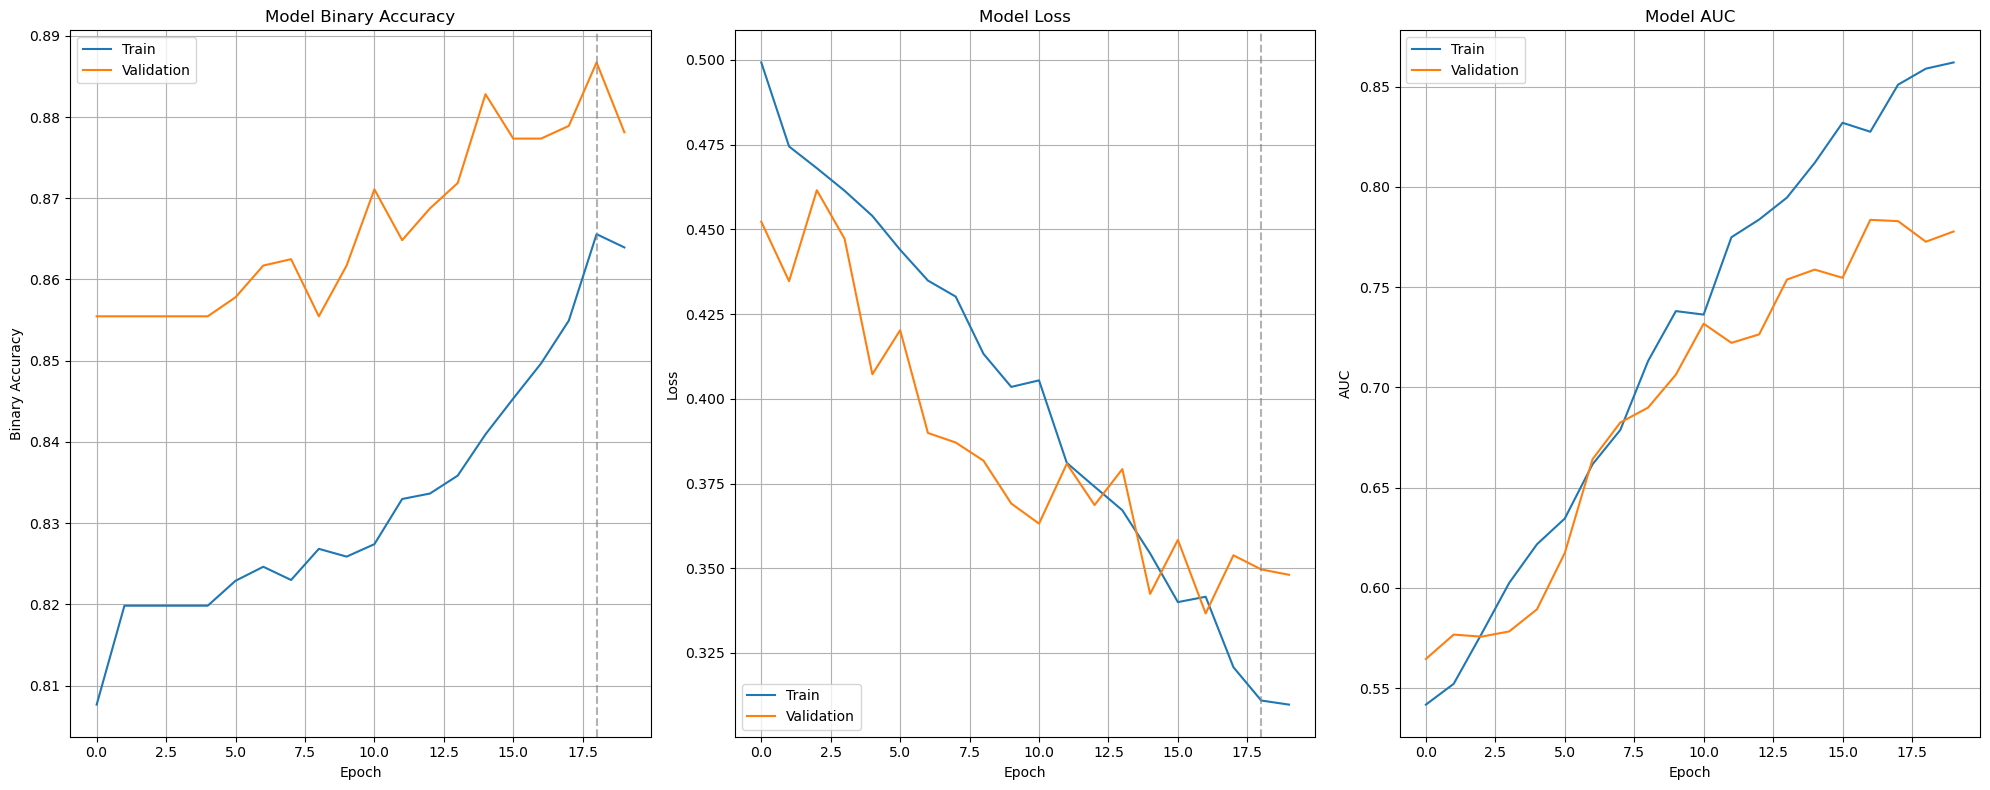

Best validation binary accuracy: 0.8867 at epoch 18


In [54]:
plt.figure(figsize=(20, 8))

# Binary Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['binary_accuracy']) 
plt.plot(history.history['val_binary_accuracy'])
best_epoch = np.argmax(history.history['val_binary_accuracy'])
plt.axvline(best_epoch, color='gray', linestyle='--', alpha=0.6)
plt.title('Model Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.axvline(best_epoch, color='gray', linestyle='--', alpha=0.6)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc']) 
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best val accuracy
bestValAccuracy = np.max(history.history['val_binary_accuracy'])
print(f'Best validation binary accuracy: {bestValAccuracy:.4f} at epoch {best_epoch}')


In [55]:
# Esegui evaluate e visualizza il risultato
results = modelCNN.evaluate(X_test, y_test, verbose=0)
print(results)  # Stampa i risultati per vedere quanti valori vengono restituiti

# Se sono più di 2 valori, puoi selezionare quello che ti interessa
testLoss = results[0]
testAccuracy = results[1]  # Oppure index corretti se ci sono più metriche

print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {testAccuracy:.4f}")

[0.31596946716308594, 0.8846153616905212, 0.8181966543197632]
Test Loss: 0.3160
Test Accuracy: 0.8846


In [56]:
modelCNN.load_weights('best_model.h5', by_name=False)

resultsTest = modelCNN.evaluate(X_test, y_test)
print('Test Loss: {} \nTest Accuracy: {}'.format(resultsTest[0], resultsTest[1]))

resultsVal = modelCNN.evaluate(X_val, y_val)
print('Val Loss: {} \nVal Accuracy: {}'.format(resultsVal[0], resultsVal[1]))

5/5 [==============================] - 2s 353ms/step - loss: 0.4503 - binary_accuracy: 0.8592 - auc: 0.5629
Test Loss: 0.4503204822540283 
Test Accuracy: 0.8592307567596436
4/4 [==============================] - 2s 496ms/step - loss: 0.4523 - binary_accuracy: 0.8555 - auc: 0.5646
Val Loss: 0.4522550106048584 
Val Accuracy: 0.85546875


In [57]:
# Predict the labels of the test set
threshold = 0.5
y_pred_probs = modelCNN.predict(X_test)                     # returns probabilities for each label (from sigmoid outputs)
y_pred_binary = (y_pred_probs > threshold).astype(int)      # if the probability of a class is higher then treshold then consider it active

5/5 [==============================] - 2s 383ms/step


In [60]:
# Confusion matrix considering the MIX as a separate lable:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert y_test back to normal label names or "MIX"
y_test_simplified = []
y_pred_simplified = []

for i, row in enumerate(y_test):
    active_indicesTest = np.where(row == 1)[0]
    active_indicesPred = np.where(y_pred_binary[i] == 1)[0]

    # Consider only single-label ground truth samples
    if len(active_indicesTest) == 1:
        true_label = mlb.classes_[active_indicesTest[0]]

        if len(active_indicesPred) > 0:
            pred_label = mlb.classes_[active_indicesPred[0]]
        else:
            pred_label = "None"

        y_test_simplified.append(true_label)
        y_pred_simplified.append(pred_label)

# Print confusion matrix
allLabels = list(mlb.classes_) + ["None"]

cm = confusion_matrix(y_test_simplified, y_pred_simplified, labels=allLabels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=allLabels)
disp.plot(cmap="Blues", xticks_rotation=45)

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets

In [112]:
from termcolor import colored

def plot_mel(mel_spec, title=""):
    plt.figure(figsize=(6, 3))
    plt.imshow(mel_spec, origin='lower', aspect='auto', cmap='magma')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def inspect_mix_errors(y_test, y_pred_binary, mlb, X_data=None, max_samples=10, plot=True):
    mix_indices = [i for i, row in enumerate(y_test) if np.sum(row) > 1]
    print(f"Found {len(mix_indices)} MIX samples (multi-label). Showing up to {max_samples}:\n")

    for idx in mix_indices[:max_samples]:
        true_labels = set(mlb.inverse_transform(np.expand_dims(y_test[idx], axis=0))[0])
        pred_labels = set(mlb.inverse_transform(np.expand_dims(y_pred_binary[idx], axis=0))[0])

        missed = true_labels - pred_labels
        extra = pred_labels - true_labels
        correct = true_labels & pred_labels

        print(f"Sample #{idx}")

        print(colored(f" -> Correct Prediction: {sorted(correct)}", 'green'))
        print(colored(f" -> False Negatives: {sorted(missed)}", 'red'))
        print(colored(f" -> False Positives: {sorted(extra)}", 'yellow'))


        if plot and X_data is not None:
            plot_mel(X_data[idx], title=f"MIX Sample #{idx} | GT: {sorted(true_labels)}")


Found 7 MIX samples (multi-label). Showing up to 10:

Sample #0
 -> Correct Prediction: ['drum set', 'guitar']
 -> False Negatives: ['vocals']
 -> False Positives: []


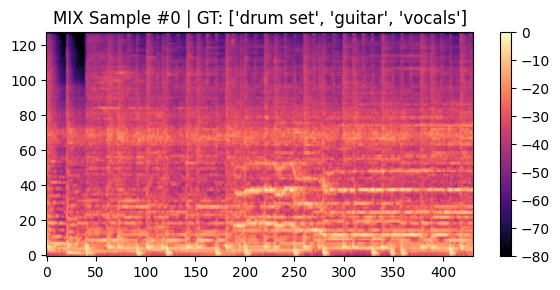

Sample #5
 -> Correct Prediction: ['guitar']
 -> False Negatives: ['drum set', 'vocals']
 -> False Positives: []


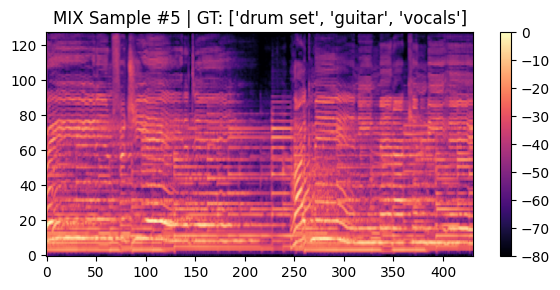

Sample #23
 -> Correct Prediction: ['drum set', 'guitar', 'vocals']
 -> False Negatives: []
 -> False Positives: []


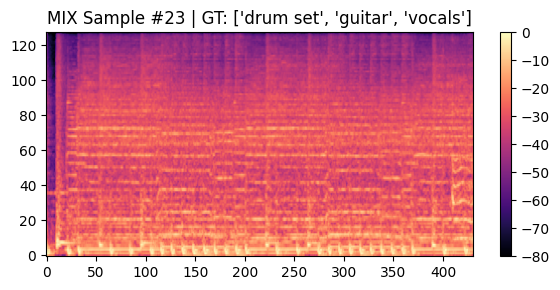

Sample #24
 -> Correct Prediction: []
 -> False Negatives: ['drum set', 'guitar', 'vocals']
 -> False Positives: []


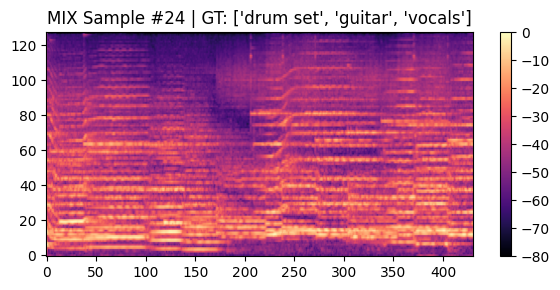

Sample #31
 -> Correct Prediction: ['guitar']
 -> False Negatives: ['drum set', 'vocals']
 -> False Positives: []


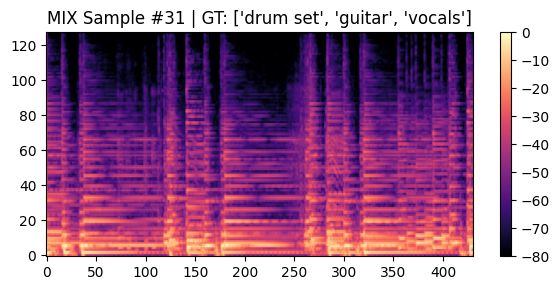

Sample #44
 -> Correct Prediction: ['drum set', 'guitar', 'vocals']
 -> False Negatives: []
 -> False Positives: []


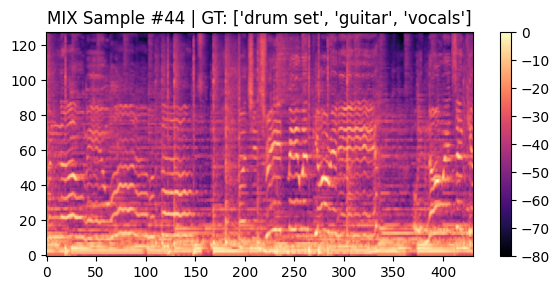

Sample #56
 -> Correct Prediction: ['vocals']
 -> False Negatives: ['drum set', 'guitar']
 -> False Positives: []


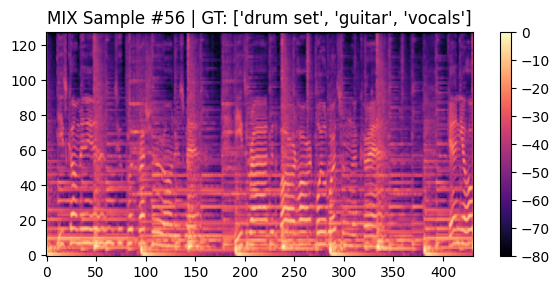

In [113]:
inspect_mix_errors(y_test, y_pred_binary, mlb, max_samples=10, X_data=X_test)

In [79]:
import pandas as pd
import numpy as np

def get_mix_matrix(y_true, y_pred, mlb, max_samples=10):
    rows = []

    # Trova MIX (campioni con più di una etichetta)
    mix_indices = [i for i, row in enumerate(y_true) if np.sum(row) > 1]

    for idx in mix_indices[:max_samples]:
        true_labels = set(mlb.inverse_transform([y_true[idx]])[0])
        pred_labels = set(mlb.inverse_transform([y_pred[idx]])[0])

        tp = sorted(true_labels & pred_labels)
        fn = sorted(true_labels - pred_labels)
        fp = sorted(pred_labels - true_labels)

        rows.append({
            'Sample': idx,
            'True Labels': sorted(true_labels),
            'Pred Labels': sorted(pred_labels),
            'TP': tp,
            'FN': fn,
            'FP': fp,
            'Correct': len(tp),
            'Missed': len(fn),
            'Wrong': len(fp)
        })

    df_mix = pd.DataFrame(rows)
    return df_mix


In [80]:
df_mix_analysis = get_mix_matrix(y_test, y_pred_binary, mlb, max_samples=15)
print(df_mix_analysis.to_string(index=False))


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
# Classification report
from sklearn.metrics import classification_report

report = classification_report(
    y_test,
    y_pred_binary,
    target_names=mlb.classes_,
    zero_division=0  
)

print(report)